In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping

%matplotlib inline
np.random.seed(42)

### Sales prediction by regression models and recurrent neural network for shampoo dataset.

The goal of this notebook is to experiment with feature engineering to test how good the application of a recurrent neural network will be for such small dataset.

In [3]:
df = pd.read_csv("shampoo.csv")
df["Month"] = df["Month"].apply(lambda x: pd.datetime.strptime('200'+x, '%Y-%m'))
df.head()

,Month,Sales
0,2001-01-01,266.0
1,2001-02-01,145.9
2,2001-03-01,183.1
3,2001-04-01,119.3
4,2001-05-01,180.3


The chart shows the presence of a trend in the time series and, possibly, some periodic component.

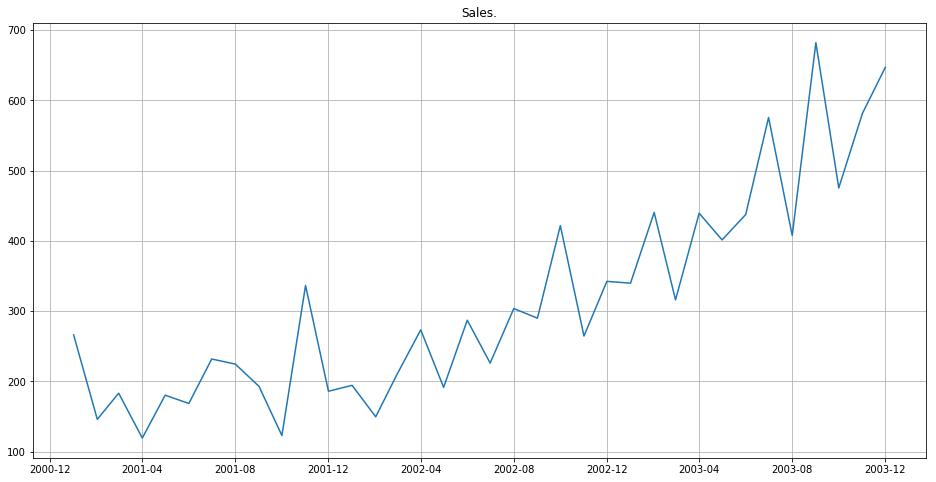

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df.set_index("Month")["Sales"])
plt.title("Sales.")
plt.grid()

Extracting a trend using a linear regression model. To assess the quality of the models, the time series is divided into the training (2/3 observations) and test sets. RMSE was used as criteria throughout the whole test set and its first half (forecast horizons for a year and 6 months).

In [5]:
reg = LinearRegression()
y = df["Sales"].values
X = np.arange(y.shape[0]).reshape(-1, 1)
X_train, X_test = X[:24], X[24:]
y_train, y_test = y[:24], y[24:]
reg.fit(X_train, y_train)
y_hat = reg.predict(X_test)
print("RMSE of linear model over year: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat))))
print("RMSE of linear model over 6 months: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test[:-6], y_pred=y_hat[:-6]))))

RMSE of linear model over year:  162.655
RMSE of linear model over 6 months:  82.104


According to the chart of the series, we can assume that the trend is non-linear. The first year, growth is rather slow, followed by acceleration. Therefore, quadratic and cubic dependencies were tested.

In [6]:
X = np.arange(y.shape[0]).reshape(-1, 1)
X2 = X**2
X = np.c_[X, X2]
X_train, X_test = X[:24], X[24:]
reg.fit(X_train, y_train)
y_hat = reg.predict(X_test)
print("RMSE of quadratic model over year: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat))))
print("RMSE of quadratic model over 6 months: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test[:-6], y_pred=y_hat[:-6]))))

RMSE of quadratic model over year:  73.908
RMSE of quadratic model over 6 months:  52.659


In [7]:
X = np.arange(y.shape[0]).reshape(-1, 1)
X2 = X**2
X3 = X**3
X = np.c_[X, X2, X3]
X_train, X_test = X[:24], X[24:]
reg.fit(X_train, y_train)
y_hat = reg.predict(X_test)
print("RMSE of cubic model over year: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat))))
print("RMSE of cubic model over 6 months: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test[:-6], y_pred=y_hat[:-6]))))

RMSE of cubic model over year:  72.518
RMSE of cubic model over 6 months:  48.329


The use of models with non-linear trends has improved prediction quality. The result of the forecast for the year improved slightly when quadratic and cubic models were combined. The achieved RMSE will be the baseline for further analysis.

In [8]:
def get_trend(pow=1):
    """ Approximates trend by a polynomial of the degree of pow. """
    y = df["Sales"].values
    X = np.arange(y.shape[0]).reshape(-1, 1)
    reg = LinearRegression()
    for p in range(pow-1):
        X_p = X[:, 0]**(p+2)
        X = np.c_[X, X_p]    
    reg.fit(X[:24], y[:24]) # The coefficients of the model are evaluated on the training set.
    trend = reg.predict(X)
    return trend, trend[:24], trend[24:]

def get_detrended(pow=1):
    """ Returns detrended series. """
    trend = get_trend(pow)[0]
    detrended = df["Sales"].values - trend
    return detrended, detrended[:24], detrended[24:]

RMSE of ensemble over year:  72.252
RMSE of ensemble over 6 months:  49.453


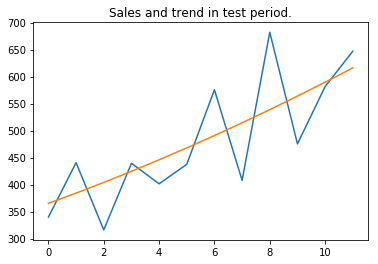

In [10]:
y_hat = 0.71*get_trend(pow=3)[2] + 0.29*get_trend(pow=2)[2]
print("RMSE of ensemble over year: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat))))
print("RMSE of ensemble over 6 months: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test[:-6], y_pred=y_hat[:-6]))))
plt.plot(y_test)
plt.plot(y_hat)
plt.title("Sales and trend in test period.")
plt.show()

Stationarity check of a time series with a removed trend, to assess its potential as the input of a neural network. A check for unit roots by the Dickey-Fuller test showed the stationarity of the series.

adf:  -5.889180926564063
p-value:  2.9520981247512006e-07
Critical values:  {'1%': -3.7112123008648155, '5%': -2.981246804733728, '10%': -2.6300945562130176}
No unit roots, series stationary.


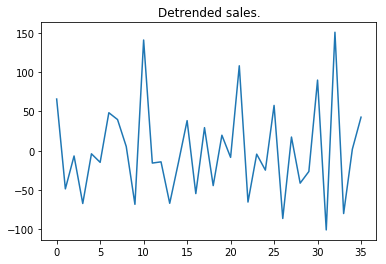

In [11]:
y_detrended = get_detrended(pow=3)[0]

test = sm.tsa.adfuller(y_detrended)
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0]> test[4]["5%"]: 
    print("Unit roots present, series not stationary.")
else:
    print("No unit roots, series stationary.")

plt.plot(y_detrended)
plt.title("Detrended sales.")
plt.show()

Testing the predictive power of the ARIMA model in this time series. A series of first differences passed stationarity test. Autocorrelation and partial autocorrelation function plots for the original series allude to the presence of autoregressive and moving average processes. The smallest error is shown by the ARIMA(2,1,0). However, none of the sets of parameters allowed to surpass the result of linear regression.  

In [12]:
""" Dickey-Fuller test for differenced series. """
y1 = df.diff(periods=1).dropna()["Sales"].values
test = sm.tsa.adfuller(y1)
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0]> test[4]["5%"]: 
    print("Unit roots present, series not stationary.")
else:
    print("No unit roots, series stationary.")

adf:  -7.249074055553853
p-value:  1.799857414168716e-10
Critical values:  {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}
No unit roots, series stationary.


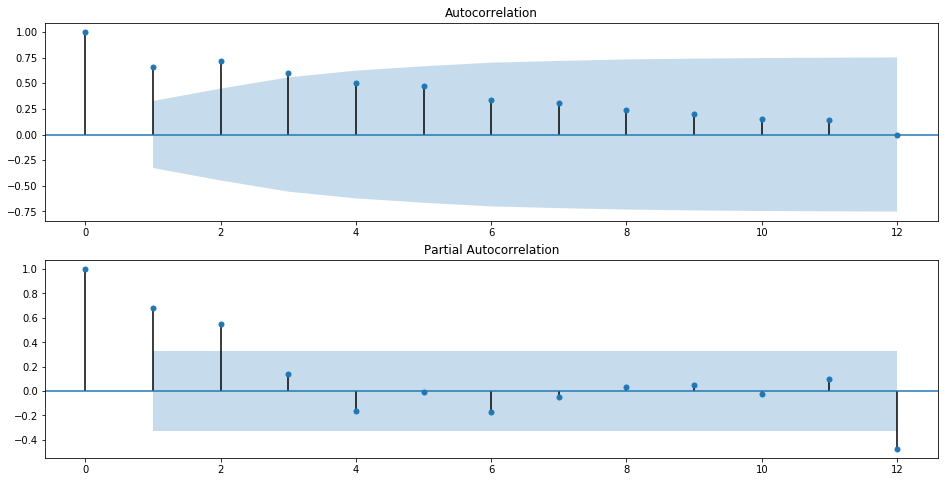

In [13]:
""" ACF and PACF plots for original series. """
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=12, ax=ax2)

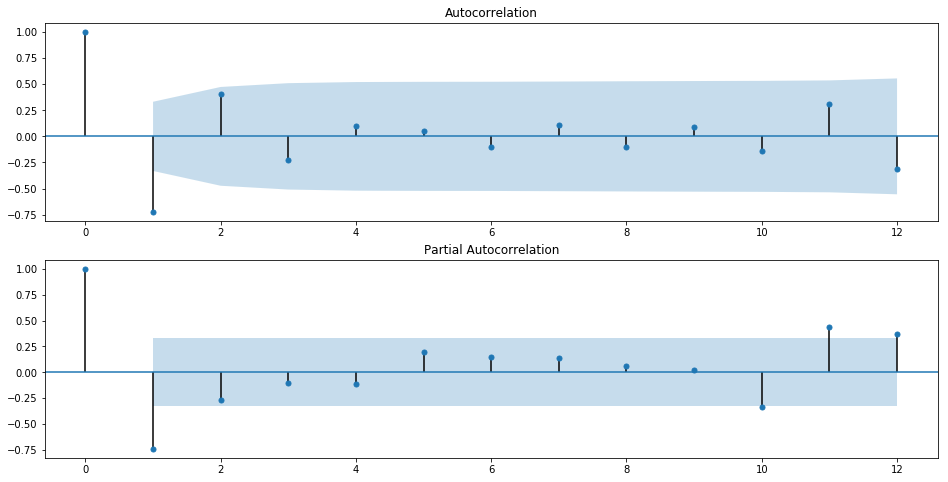

In [15]:
""" ACF and PACF plots for series of first differences. """
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y1, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y1, lags=12, ax=ax2)

RMSE ARIMA for year:  77.571
RMSE ARIMA for 6 months:  52.854


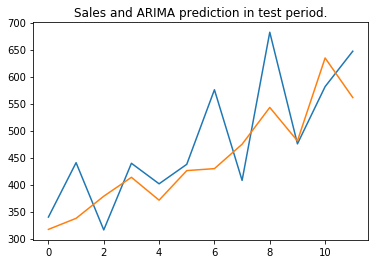

In [16]:
""" Fitting and testing ARIMA(2,1,0). """
history = [y for y in y_train]
y_hat = []
for t in range(len(y_test)):    
    model = ARIMA(history, order=(2,1,0))
    try:
        model_fit = model.fit()
    except:
        y_hat.append(history[-1])
        history.append(y_test[t])
        continue
    output = model_fit.forecast()
    pred = output[0]
    y_hat.append(pred)    
    history.append(y_test[t])    
print("RMSE ARIMA for year: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat))))
print("RMSE ARIMA for 6 months: {0: .3f}".format(np.sqrt(mean_squared_error(y_true=y_test[:-6], y_pred=y_hat[:-6]))))

plt.plot(y_test)
plt.plot(y_hat)
plt.title("Sales and ARIMA prediction in test period.")
plt.show()

Recurrent neural network for sales prediction.

Data for input to the network is made in the prepare_data() function. It makes time lags, differences if needed, train/test splits. The independed variables then were scaled to tahn interval (-1, 1). Scaling coefficients were determined on training set, to avoid data leaks.

There was manual control of training epochs with "stateful" mode turned on for RNN within epoch. LSTM and GRU cells were tested, and LSTM's produced better results for this dataset. Dropout was used for regularization. If validation error did not decrease for a number of epochs, an early stop was used.

In [21]:
def prepare_data(data, lag=1, val=0, do_diff=True):  
    pdf = pd.DataFrame(data, columns=["y"])
    target_col = "y"
    if do_diff:
        # Differences.
        pdf["diff"] = pdf["y"].diff()
        full = pdf["diff"].values
        target_col = "diff"
    else:
        full = pdf["y"].values
        
    # Makes lag columns
    lag_cols = []
    for i in range(lag):
        pdf["lag_{}".format(i+1)] = pdf[target_col].shift(i+1)
        lag_cols.append("lag_{}".format(i+1))
    pdf.fillna(0, inplace=True)
    
    
    lagged = pdf[lag_cols].values
    full = np.c_[full, lagged]
    if val==0:
        train, test = full[lag:24], full[24:]    
        return train, test
    else:
        train, val, test = full[lag:16], full[16:24], full[24:]    
        return train, val, test

In [22]:
train, test = prepare_data(df["Sales"].values, lag=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

Using differenced series with one lag as input feature to make one step prediction.

In [19]:
def fit_rnn(train, batch_size, nb_epoch, neurons, patience=500, verbose=1):
    X, y = train[:, 1:], train[:, 0]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(layers.LSTM(neurons, 
                          batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                          dropout=0.2, recurrent_dropout=0.2,
                          return_sequences=True,
                          stateful=True))    
    model.add(layers.LSTM(neurons,                           
                          dropout=0.2, recurrent_dropout=0.2,                          
                          stateful=True))    
    model.add(layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    losses = []
    loss = np.inf
    for i in range(nb_epoch):
        if verbose > 0:
            print("epoch {}".format(i))
        history = model.fit(X, y, epochs=1, batch_size=batch_size, verbose=verbose, shuffle=False, validation_split=0.3)        
        if history.history["val_loss"][-1] < loss:
            loss = history.history["val_loss"][-1]
            weights = model.get_weights()
            best_epoch = i        
        
        model.reset_states()
        
        if i - best_epoch > patience:            
            break
            
    model.set_weights(weights)
    if verbose > 0:
        print("Restoring weights for epoch {} with loss {}".format(best_epoch, loss))
    return model

In [23]:
model = fit_rnn(train_scaled, 1, 3000, 16, verbose=0)

Functions for transforming network predictions. Predict_rnn() gets network output and rescales it back to original scale. Get_result_iteratively() transforms series from differences, taking into account that each step the true previous value is already known and one next is being predicted. For this, the predicted value of a differenced series is added to the previous true one, while the neural network is not retrained. Unlike that iterative prediction, the get_result() function makes a one-time forecast for the entire test period, using only the last value from training set and the cumulative sum of the predicted series of differences.

In [24]:
def predict_rnn(model, train_scaled, test_scaled):
    train_reshaped = train_scaled[:, 1:].reshape(len(train_scaled), 1, train_scaled[:, 1:].shape[1])
    train_hat = model.predict(train_reshaped, batch_size=1)
    test_reshaped = test_scaled[:, 1:].reshape(len(test_scaled), 1, test_scaled[:, 1:].shape[1])
    test_scaled_hat = model.predict(test_reshaped, batch_size=1)
    test_scaled_b = test_scaled.copy()
    test_scaled_b[:, 0] = test_scaled_hat[:, 0]
    test_hat = scaler.inverse_transform(test_scaled_b)
    return test_hat
    
def get_result_iteratively(test_hat, trend=None, plot=False):    
    for i in range(23, 35):
        if trend is not None:
            s = trend[i-23]
        else:
            s = df["Sales"].iloc[i]
        y_hat[i-23] = test_hat[i-23, 0] + s

    rmse_12 = np.sqrt(mean_squared_error(y_true=df["Sales"].iloc[24:].values, y_pred=y_hat))
    rmse_6 = np.sqrt(mean_squared_error(y_true=df["Sales"].iloc[24:-6].values, y_pred=y_hat[:-6]))
    print("RMSE for year: {0: .3f}".format(rmse_12))
    print("RMSE for 6 months: {0: .3f}".format(rmse_6))
    if plot:
        plt.plot(df["Sales"].iloc[24:].values)
        plt.plot(y_hat)
    return rmse_12, rmse_6
    
def get_result(test_hat, trend=None, plot=False):
    if trend is not None:
        s = trend
    else:
        s = df["Sales"].iloc[23]
    y_hat = test_hat[:, 0].cumsum() + s
    
    rmse_12 = np.sqrt(mean_squared_error(y_true=df["Sales"].iloc[24:].values, y_pred=y_hat))
    rmse_6 = np.sqrt(mean_squared_error(y_true=df["Sales"].iloc[24:-6].values, y_pred=y_hat[:-6]))
    print("RMSE for year: {0: .3f}".format(rmse_12))
    print("RMSE for 6 months: {0: .3f}".format(rmse_6))
    if plot:
        plt.plot(df["Sales"].iloc[24:].values)
        plt.plot(y_hat)
    return rmse_12, rmse_6

RMSE for year:  95.677
RMSE for 6 months:  48.411


(95.67729656008954, 48.410779046076435)

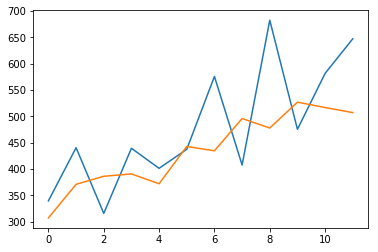

In [25]:
test_hat = predict_rnn(model, train_scaled=train_scaled, test_scaled=test_scaled)
get_result_iteratively(test_hat, plot=True)

RMSE for year:  251.171
RMSE for 6 months:  83.199


(251.1710454482775, 83.1992379052109)

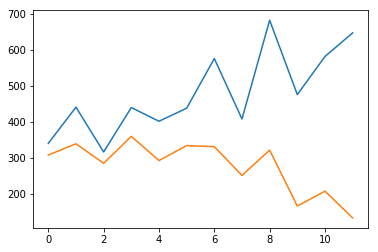

In [26]:
get_result(test_hat, plot=True)

The method of making prediction, that takes into account the true values for each previous period, allowed to achieve errors in the 6-month horizon, comparable with the result of the regression model. To test the robustness of this solution, several network training cycles were conducted.

In [27]:
import time
def multifit(train_scaled, test_scaled, trend=None, num=10):
    errors_i_12, errors_i_6, errors_12, errors_6 = [], [], [], []
    for i in range(num):
        start_time = time.time()
        print("Iteration: {}".format(i))
        model = fit_rnn(train_scaled, 1, 3000, 16, verbose=0)
        test_hat = predict_rnn(model=model, train_scaled=train_scaled, test_scaled=test_scaled)
        rmse_i_12, rmse_i_6 = get_result_iteratively(test_hat, trend=trend, plot=False)
        rmse_12, rmse_6 = get_result(test_hat, trend=trend, plot=False)
        errors_i_12.append(rmse_i_12)
        errors_i_6.append(rmse_i_6)
        errors_12.append(rmse_12)
        errors_6.append(rmse_6)
        end_time = time.time()
        print("Iteration time: {}".format(end_time - start_time))
    return errors_i_12, errors_i_6, errors_12, errors_6

In [28]:
errors_i_12, errors_i_6, errors_12, errors_6 = multifit(train_scaled=train_scaled, test_scaled=test_scaled, num=10)

Iteration: 0
RMSE for year:  105.261
RMSE for 6 months:  57.344
RMSE for year:  338.118
RMSE for 6 months:  124.974
Iteration time: 127.9826250076294
Iteration: 1
RMSE for year:  105.179
RMSE for 6 months:  60.106
RMSE for year:  347.957
RMSE for 6 months:  132.942
Iteration time: 124.19181799888611
Iteration: 2
RMSE for year:  106.870
RMSE for 6 months:  57.951
RMSE for year:  333.851
RMSE for 6 months:  122.275
Iteration time: 147.74785947799683
Iteration: 3
RMSE for year:  97.531
RMSE for 6 months:  51.291
RMSE for year:  206.045
RMSE for 6 months:  54.926
Iteration time: 132.33503246307373
Iteration: 4
RMSE for year:  94.886
RMSE for 6 months:  48.131
RMSE for year:  232.070
RMSE for 6 months:  68.922
Iteration time: 127.53122401237488
Iteration: 5
RMSE for year:  76.816
RMSE for 6 months:  42.775
RMSE for year:  80.541
RMSE for 6 months:  43.597
Iteration time: 122.47681522369385
Iteration: 6
RMSE for year:  107.812
RMSE for 6 months:  60.022
RMSE for year:  384.009
RMSE for 6 mon

In [29]:
print("Median RMSE of iterative prediction for year: {0: .3f}".format(np.median(errors_i_12)))
print("Median RMSE of iterative prediction for 6 months: {0: .3f}".format(np.median(errors_i_6)))
print("Median RMSE of one-time prediction for year: {0: .3f}".format(np.median(errors_12)))
print("Median RMSE of one-time prediction for 6 months: {0: .3f}".format(np.median(errors_6)))

Median RMSE of iterative prediction for year:  103.029
Median RMSE of iterative prediction for 6 months:  56.538
Median RMSE of one-time prediction for year:  305.929
Median RMSE of one-time prediction for 6 months:  110.359


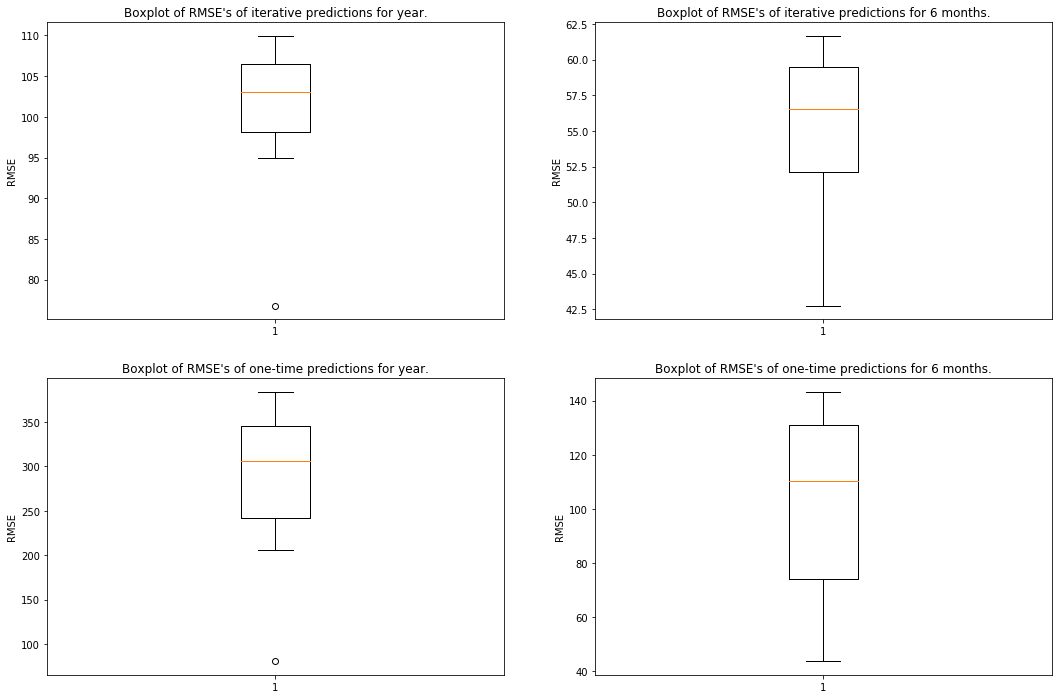

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].boxplot(errors_i_12)
ax[0, 0].set_title("Boxplot of RMSE's of iterative predictions for year.")
ax[0, 0].set_ylabel("RMSE")
ax[0, 1].boxplot(errors_i_6)
ax[0, 1].set_title("Boxplot of RMSE's of iterative predictions for 6 months.")
ax[0, 1].set_ylabel("RMSE")
ax[1, 0].boxplot(errors_12)
ax[1, 0].set_title("Boxplot of RMSE's of one-time predictions for year.")
ax[1, 0].set_ylabel("RMSE")
ax[1, 1].boxplot(errors_6)
ax[1, 1].set_title("Boxplot of RMSE's of one-time predictions for 6 months.")
ax[1, 1].set_ylabel("RMSE")
plt.show()

In this sample of results from ten networks, only iterative method of making prediction on the six months horizon is close in quality to the regression model. A one-time forecast has a high spread of results.

Next are tests of the ability to improve the predictive power of a neural network by adding features. For this, series obtained by subtracting the quadratic and cubic trend from the initial one were included as independent variables. The expectation is that removing the trend and bringing the series to stationary makes the model easier to see the dependencies in the data. The quality of the model was again evaluated by training networks several times to see the distribution of errors.

In [31]:
train, test = prepare_data(df["Sales"].values, lag=1)

train_t, test_t = prepare_data(get_detrended(pow=2)[0], lag=1, do_diff=False)
train = np.c_[train, train_t[:, -1]]
test = np.c_[test, test_t[:, -1]]

train_t, test_t = prepare_data(get_detrended(pow=3)[0], lag=1, do_diff=False)
train = np.c_[train, train_t[:, -1]]
test = np.c_[test, test_t[:, -1]]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [32]:
errors_i_12, errors_i_6, errors_12, errors_6 = multifit(train_scaled=train_scaled, test_scaled=test_scaled, num=10)

Iteration: 0
RMSE for year:  64.412
RMSE for 6 months:  36.354
RMSE for year:  47.290
RMSE for 6 months:  39.667
Iteration time: 133.53623461723328
Iteration: 1
RMSE for year:  64.267
RMSE for 6 months:  35.772
RMSE for year:  47.817
RMSE for 6 months:  32.455
Iteration time: 136.4846396446228
Iteration: 2
RMSE for year:  65.548
RMSE for 6 months:  35.166
RMSE for year:  73.428
RMSE for 6 months:  31.607
Iteration time: 131.2274308204651
Iteration: 3
RMSE for year:  64.898
RMSE for 6 months:  34.445
RMSE for year:  81.722
RMSE for 6 months:  28.123
Iteration time: 134.62823629379272
Iteration: 4
RMSE for year:  68.694
RMSE for 6 months:  34.400
RMSE for year:  120.299
RMSE for 6 months:  41.098
Iteration time: 137.67024159431458
Iteration: 5
RMSE for year:  63.657
RMSE for 6 months:  32.770
RMSE for year:  107.976
RMSE for 6 months:  33.595
Iteration time: 136.9380407333374
Iteration: 6
RMSE for year:  63.132
RMSE for 6 months:  40.823
RMSE for year:  85.687
RMSE for 6 months:  67.776


In [33]:
print("Median RMSE of iterative prediction for year: {0: .3f}".format(np.median(errors_i_12)))
print("Median RMSE of iterative prediction for 6 months: {0: .3f}".format(np.median(errors_i_6)))
print("Median RMSE of one-time prediction for year: {0: .3f}".format(np.median(errors_12)))
print("Median RMSE of one-time prediction for 6 months: {0: .3f}".format(np.median(errors_6)))

Median RMSE of iterative prediction for year:  64.655
Median RMSE of iterative prediction for 6 months:  35.469
Median RMSE of one-time prediction for year:  83.704
Median RMSE of one-time prediction for 6 months:  37.247


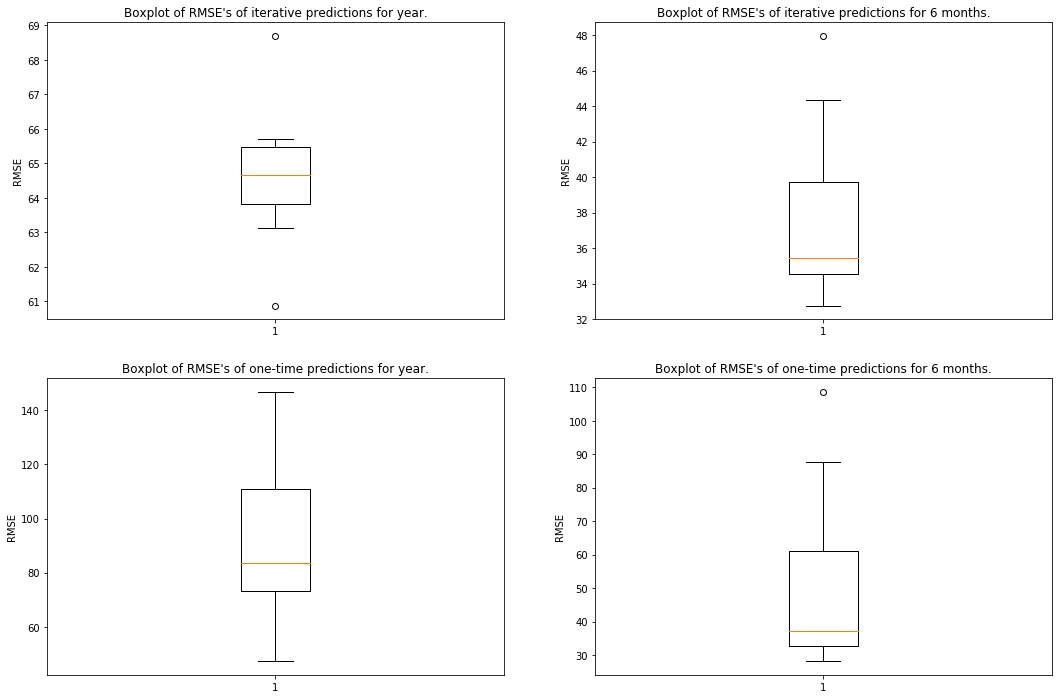

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].boxplot(errors_i_12)
ax[0, 0].set_title("Boxplot of RMSE's of iterative predictions for year.")
ax[0, 0].set_ylabel("RMSE")
ax[0, 1].boxplot(errors_i_6)
ax[0, 1].set_title("Boxplot of RMSE's of iterative predictions for 6 months.")
ax[0, 1].set_ylabel("RMSE")
ax[1, 0].boxplot(errors_12)
ax[1, 0].set_title("Boxplot of RMSE's of one-time predictions for year.")
ax[1, 0].set_ylabel("RMSE")
ax[1, 1].boxplot(errors_6)
ax[1, 1].set_title("Boxplot of RMSE's of one-time predictions for 6 months.")
ax[1, 1].set_ylabel("RMSE")
plt.show()

With those features, all forecast options, except for the one-time forecast on the annual horizon, were able to exceed the quality baseline set by the regression model. Although boxplot for iterative predicting contains outliers, the overall spread of the results is quite compact. That can not be said about the one-time forecasting method for the entire horizon.

In the following model, the detrended series is the target variable. It is stationary, as was checked earlier, and it does not need to be differenced. In addition, when making iterative prediction, it is not needed to wait for each new true value. Instead, the trend can be added to the back-scaled output of the neural network, which was calculated on the training sample. Thus, this prediction also becomes "one-time" for the entire horizon. The reliability of the model was again tested by training ten networks.

In [35]:
train, test = prepare_data(get_detrended(pow=3)[0], lag=0, do_diff=False)

train_t, test_t = prepare_data(get_detrended(pow=2)[0], lag=1, do_diff=False)
train = np.c_[train[1:], train_t[:, -1]]
test = np.c_[test, test_t[:, -1]]

train_t, test_t = prepare_data(get_detrended(pow=3)[0], lag=1, do_diff=False)
train = np.c_[train, train_t[:, -1]]
test = np.c_[test, test_t[:, -1]]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [36]:
errors_i_12, errors_i_6, errors_12, errors_6 = multifit(train_scaled=train_scaled, 
                                                        test_scaled=test_scaled, 
                                                        trend = get_trend(pow=3)[2],
                                                        num=10)

Iteration: 0
RMSE for year:  63.993
RMSE for 6 months:  39.251
RMSE for year:  108.310
RMSE for 6 months:  42.448
Iteration time: 379.7202670574188
Iteration: 1
RMSE for year:  60.510
RMSE for 6 months:  46.754
RMSE for year:  95.369
RMSE for 6 months:  62.180
Iteration time: 144.34805345535278
Iteration: 2
RMSE for year:  62.395
RMSE for 6 months:  38.025
RMSE for year:  140.634
RMSE for 6 months:  64.547
Iteration time: 146.18785691261292
Iteration: 3
RMSE for year:  63.917
RMSE for 6 months:  55.838
RMSE for year:  187.456
RMSE for 6 months:  109.376
Iteration time: 147.2038586139679
Iteration: 4
RMSE for year:  63.355
RMSE for 6 months:  49.493
RMSE for year:  116.493
RMSE for 6 months:  64.236
Iteration time: 145.3610553741455
Iteration: 5
RMSE for year:  58.537
RMSE for 6 months:  36.753
RMSE for year:  134.939
RMSE for 6 months:  79.002
Iteration time: 321.34496426582336
Iteration: 6
RMSE for year:  60.999
RMSE for 6 months:  53.538
RMSE for year:  206.337
RMSE for 6 months:  10

In [37]:
print("Median RMSE of iterative prediction for year: {0: .3f}".format(np.median(errors_i_12)))
print("Median RMSE of iterative prediction for 6 months: {0: .3f}".format(np.median(errors_i_6)))
print("Median RMSE of one-time prediction for year: {0: .3f}".format(np.median(errors_12)))
print("Median RMSE of one-time prediction for 6 months: {0: .3f}".format(np.median(errors_6)))

Median RMSE of iterative prediction for year:  62.494
Median RMSE of iterative prediction for 6 months:  46.967
Median RMSE of one-time prediction for year:  115.751
Median RMSE of one-time prediction for 6 months:  63.208


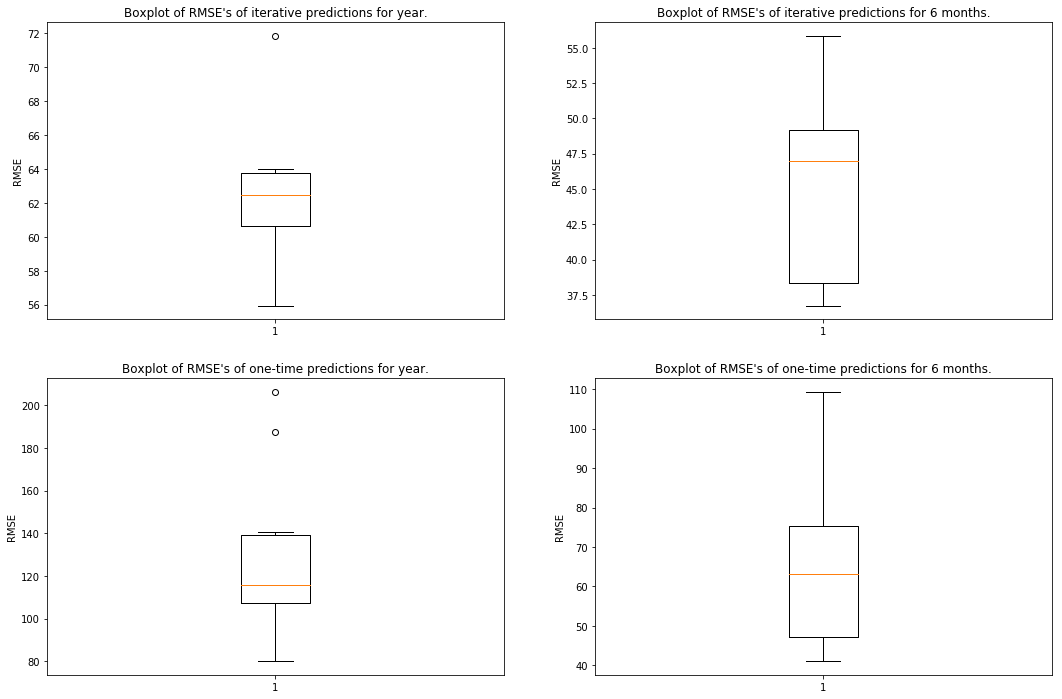

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].boxplot(errors_i_12)
ax[0, 0].set_title("Boxplot of RMSE's of iterative predictions for year.")
ax[0, 0].set_ylabel("RMSE")
ax[0, 1].boxplot(errors_i_6)
ax[0, 1].set_title("Boxplot of RMSE's of iterative predictions for 6 months.")
ax[0, 1].set_ylabel("RMSE")
ax[1, 0].boxplot(errors_12)
ax[1, 0].set_title("Boxplot of RMSE's of one-time predictions for year.")
ax[1, 0].set_ylabel("RMSE")
ax[1, 1].boxplot(errors_6)
ax[1, 1].set_title("Boxplot of RMSE's of one-time predictions for 6 months.")
ax[1, 1].set_ylabel("RMSE")
plt.show()

With these features, iterative predictions were able to exceed the quality baseline set at the beginning. And with this approach, iterative method, although it does not use the true values from the test period at all, on the annual horizon was able to surpass the result of the corresponding method of the previous model. On the other hand, the spread in RMSE values has increased here. The reason may be that with this set of variables the network did not see the values from the original series at all, but was trained only on detrended series. As well as the sum of the errors of the regression and network predictions.

In general, a recurrent neural network has coped with the task of predicting such a small dataset. Perhaps further experiments with features may improve the result.